### Text Embedding
 - 앞서 n-gram model 에서 했던 것 처럼, 단순히 단어 단위로 저장하면 문제가 생긴다.
 - 비슷한 의미를 지닌 글자들이 전혀 고려가 되지 않기 때문이다. (ex. 식탁 / 탁자 를 완전히 다른 단어로 구분 함)
 - 이런 비슷한 의미를 지닌 단어들은 서로 가까운 위치에 놓여야 한다.
 - 단어를 기호가 아닌, 의미를 가질 수 있게 벡터 공간에 맵핑하는 것을 의미한다.


### Word2Vec: Embedding을 학습하는 방법

Word2Vec은 Embedding을 직접 학습하는 가장 대표적인 방법이다.

핵심 아이디어는 단순하다:

같은 문맥에서 등장하는 단어들은 비슷한 의미를 가진다.

### Skip-gram 방식

중심 단어(center word)를 보고
주변 단어(context word)를 맞히도록 학습한다.

예시 문장:
 - 나는 오늘 학교에 간다

윈도우 크기 = 2 라면,
입력(center): 오늘
출력(context): 나는, 학교에

이런 쌍들을 대량으로 만들고,
이 쌍을 잘 맞히도록 embedding을 학습한다.

### 한국어를 위한 특수 고려
 - 영 단어는 단순히 공백단위로 잘라도 어느정도는 동작 하지만
 - 한국어는 단어에 조사가 거의 다 붙기 때문에 조사 정도는 분리해서 학습 시키는 것이 좀 더 유리하다.
 - 물론 영어도 접두 / 접미사 의 경우 분리해서 학습하는 것이 사전 공간을 더 아낄 수 있다.

In [1]:
import re, os

DATA_DIR = "../kowikitext_dataset"

def load_and_clean_txt(path):
    out = []
    with open(path, "r", encoding="utf-8") as f:
        for line in f:
            line = re.sub(r"\s+", " ", line).strip()
            if not line:
                continue
            out.append(line)
    return out

train_texts = load_and_clean_txt(f"{DATA_DIR}/kowikitext_20240301.train")
print(len(train_texts), train_texts[0][:120])

15068050 = 틀:원소 정보/헬륨 =


In [ ]:
from kiwipiepy import Kiwi
kiwi = Kiwi()

def tok_whitespace(line: str):
    return line.split(" ")

# 형태소 분석 토큰화
def tok_morph(line: str):
    return [t.form for t in kiwi.tokenize(line)]

In [4]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from collections import Counter
import math

In [5]:
def build_tokens(texts, tokenizer, max_lines=80_000, max_tokens=700_000):
    tokens = []
    for line in texts[:max_lines]:
        toks = tokenizer(line)
        if toks:
            tokens.extend(toks)
        if len(tokens) >= max_tokens:
            break
    return tokens

ws_tokens = build_tokens(train_texts, tok_whitespace)
mo_tokens = build_tokens(train_texts, tok_morph)

len(ws_tokens), len(mo_tokens), ws_tokens[:10], mo_tokens[:10]

(700001,
 700048,
 ['=', '틀:원소', '정보/헬륨', '=', '=', '분류:세기별', '탄자니아', '사람', '=', '='],
 ['=', '틀', ':', '원소', '정보', '/', '헬륨', '=', '=', '분류'])

In [6]:
def build_vocab(tokens, min_count=5, vocab_size=30_000):
    counter = Counter(tokens)
    # min_count 필터
    items = [(w,c) for w,c in counter.items() if c >= min_count]
    # 빈도순 정렬
    items.sort(key=lambda x: (-x[1], x[0]))
    # vocab_size 제한
    items = items[:max(0, vocab_size-1)]
    itos = ["<unk>"] + [w for w,_ in items]
    stoi = {w:i for i,w in enumerate(itos)}
    return itos, stoi, counter

def encode(tokens, stoi):
    unk = stoi["<unk>"]
    return [stoi.get(w, unk) for w in tokens]

ws_itos, ws_stoi, ws_counter = build_vocab(ws_tokens, min_count=5, vocab_size=30_000)
mo_itos, mo_stoi, mo_counter = build_vocab(mo_tokens, min_count=5, vocab_size=30_000)

ws_ids = encode(ws_tokens, ws_stoi)
mo_ids = encode(mo_tokens, mo_stoi)

len(ws_itos), len(mo_itos)

(18768, 10123)

In [7]:
def make_pairs(ids, window=2, max_pairs=400_000, skip_unk=True, unk_id=0):
    pairs = []
    n = len(ids)
    for i in range(n):
        center = ids[i]
        if skip_unk and center == unk_id:
            continue
        left = max(0, i-window)
        right = min(n, i+window+1)
        for j in range(left, right):
            if j == i:
                continue
            ctx = ids[j]
            if skip_unk and ctx == unk_id:
                continue
            pairs.append((center, ctx))
            if len(pairs) >= max_pairs:
                return np.array(pairs, dtype=np.int64)
    return np.array(pairs, dtype=np.int64)


In [8]:
def neg_distribution(counter, itos, power=0.75):
    freq = np.zeros(len(itos), dtype=np.float64)
    for i, w in enumerate(itos):
        if w == "<unk>":
            freq[i] = 1.0
        else:
            freq[i] = counter.get(w, 0)
    p = np.power(freq, power)
    p = p / p.sum()
    return p


In [ ]:
class SGNS(nn.Module):
    def __init__(self, vocab_size, dim):
        super().__init__()
        self.in_embed = nn.Embedding(vocab_size, dim)
        self.out_embed = nn.Embedding(vocab_size, dim)

    def forward(self, center, pos, neg):
        v = self.in_embed(center)          # (B, D)
        u_pos = self.out_embed(pos)        # (B, D)
        u_neg = self.out_embed(neg)        # (B, N, D)

        pos_score = (v * u_pos).sum(dim=1)                 # (B,)
        pos_loss = F.logsigmoid(pos_score)                 # (B,)

        neg_score = torch.einsum("bd,bkd->bk", v, u_neg)    # (B, N)
        neg_loss = F.logsigmoid(-neg_score).sum(dim=1)      # (B,)

        return -(pos_loss + neg_loss).mean()


In [13]:
def train_word2vec_sgns(
    ids, itos, counter,
    dim=100, window=2, max_pairs=400_000,
    neg_k=10, batch=512, epochs=2, lr=2e-3,
    seed=0
):
    import numpy as np
    import torch
    import torch.nn as nn
    import torch.nn.functional as F

    np.random.seed(seed)
    torch.manual_seed(seed)

    pairs = make_pairs(ids, window=window, max_pairs=max_pairs, unk_id=0)
    np.random.shuffle(pairs)

    p = neg_distribution(counter, itos)
    V = len(itos)

    device = "cuda" if torch.cuda.is_available() else "cpu"
    model = SGNS(V, dim).to(device)
    opt = torch.optim.Adam(model.parameters(), lr=lr)

    def sample_neg(bsz):
        return np.random.choice(V, size=(bsz, neg_k), replace=True, p=p)

    for ep in range(1, epochs + 1):
        np.random.shuffle(pairs)
        total_loss = 0.0
        steps = 0

        for i in range(0, len(pairs) - batch + 1, batch):
            b = pairs[i:i+batch]
            center = torch.tensor(b[:, 0], device=device)
            pos    = torch.tensor(b[:, 1], device=device)
            neg    = torch.tensor(sample_neg(batch), device=device)

            opt.zero_grad()
            loss = model(center, pos, neg)
            loss.backward()
            opt.step()

            total_loss += loss.item()
            steps += 1

        avg_loss = total_loss / max(steps, 1)
        print(f"[epoch {ep}] avg loss: {avg_loss:.4f}")

    emb = model.in_embed.weight.detach().cpu()
    return model, emb, pairs


In [14]:
# 공백 단위
ws_model, ws_emb, _ = train_word2vec_sgns(
    ws_ids, ws_itos, ws_counter,
    dim=100, window=2, max_pairs=400_000,
    neg_k=10, batch=512, epochs=2, lr=2e-3, seed=0
)

[epoch 1] avg loss: 36.5736
[epoch 2] avg loss: 27.3949


In [15]:
# 형태소 단위
mo_model, mo_emb, _ = train_word2vec_sgns(
    mo_ids, mo_itos, mo_counter,
    dim=100, window=2, max_pairs=400_000,
    neg_k=10, batch=512, epochs=2, lr=2e-3, seed=0
)

[epoch 1] avg loss: 30.8980
[epoch 2] avg loss: 16.1393


In [16]:
import os, torch
os.makedirs("./models", exist_ok=True)

torch.save({"itos": ws_itos, "emb": ws_emb}, "./models/word2vec_space.pt")
torch.save({"itos": mo_itos, "emb": mo_emb}, "./models/word2vec_morph.pt")
print("saved.")

saved.


In [18]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

def get_vec(word, itos, emb):
    try:
        idx = itos.index(word)
    except ValueError:
        return None
    v = emb[idx].numpy()
    v = v / (np.linalg.norm(v) + 1e-12)
    return v

def plot_words_pca(title, words, itos, emb):
    vecs, labels = [], []
    missing = []

    for w in words:
        v = get_vec(w, itos, emb)
        if v is None:
            missing.append(w)
            continue
        vecs.append(v)
        labels.append(w)

    if len(vecs) < 2:
        print("시각화할 단어 벡터가 부족함. 누락:", missing)
        return

    X = np.stack(vecs, axis=0)
    X2 = PCA(n_components=2).fit_transform(X)

    plt.figure(figsize=(9, 7))
    plt.scatter(X2[:,0], X2[:,1])
    for i, w in enumerate(labels):
        plt.text(X2[i,0], X2[i,1], w, fontsize=12)
    plt.title(title)
    plt.show()

    if missing:
        print("누락 단어: ", missing)


In [28]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
plt.rcParams["font.family"] = "Malgun Gothic"
plt.rcParams["axes.unicode_minus"] = False

def get_vec(word, itos, emb):
    # emb: (V, D)
    try:
        idx = itos.index(word)
    except ValueError:
        return None
    v = emb[idx].numpy()
    # 정규화하면 거리 비교가 더 안정적
    v = v / (np.linalg.norm(v) + 1e-12)
    return v

def plot_words_pca(title, words, itos, emb):
    vecs, labels = [], []
    missing = []

    for w in words:
        v = get_vec(w, itos, emb)
        if v is None:
            missing.append(w)
            continue
        vecs.append(v)
        labels.append(w)

    if len(vecs) < 2:
        print("시각화할 단어 벡터가 부족함. 누락:", missing)
        return

    X = np.stack(vecs, axis=0)
    X2 = PCA(n_components=2).fit_transform(X)

    plt.figure(figsize=(9, 7))
    plt.scatter(X2[:,0], X2[:,1])
    for i, w in enumerate(labels):
        plt.text(X2[i,0], X2[i,1], w, fontsize=12)
    plt.title(title)
    plt.show()

    if missing:
        print("[누락 단어]", missing)


In [24]:
words_to_plot_ws = [
    "한국", "대한민국", "서울", "정부", "대통령",
    "경제", "시장", "기업",
    "축구", "야구", "게임", "모델"
]

words_to_plot_mo = [
    "한국", "대한민국", "서울", "정부",
    "경제", "시장",
    "축구", "야구",
]

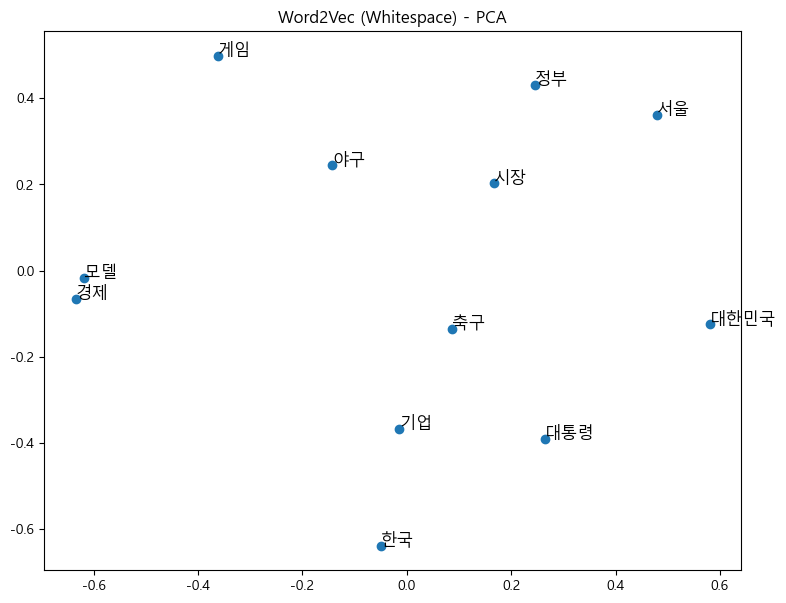

In [29]:
plot_words_pca("Word2Vec (Whitespace) - PCA", words_to_plot_ws, ws_itos, ws_emb)

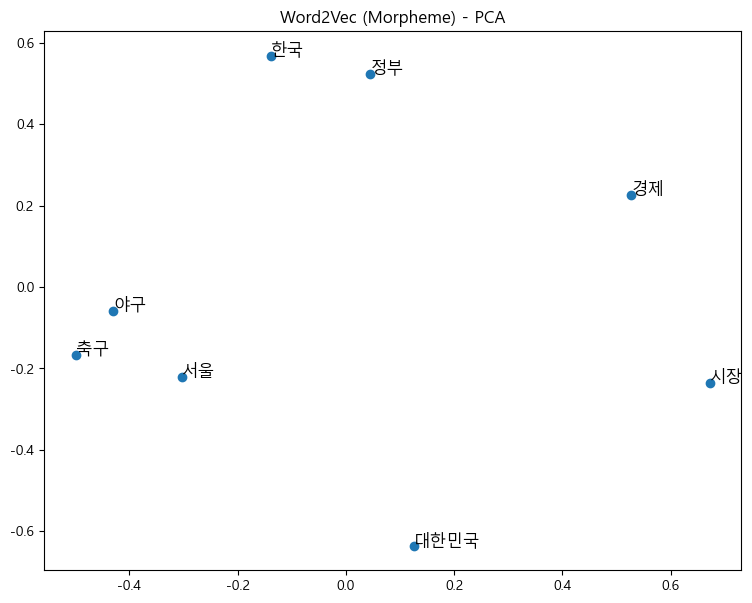

In [30]:
plot_words_pca("Word2Vec (Morpheme) - PCA", words_to_plot_mo, mo_itos, mo_emb)

In [ ]:
### 혹시 해당 단어가 사전 속에 있는지 찾고 싶다면

'''
def find_contains(substr, itos, topk=30):
    hits = [w for w in itos if substr in w]
    return hits[:topk]

find_contains("한국", ws_itos)
find_contains("한국", mo_itos)
'''